In [6]:
# Step 1: 필요한 패키지 import 하기
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 이미지 경로 설정
my_image_path = 'aiffel/camera_sticker/images/image.jpg'  # 본인 셀카 이미지 경로
whiskers_path = 'aiffel/camera_sticker/images/cat-whiskers.png'  # 고양이 수염 이미지 경로

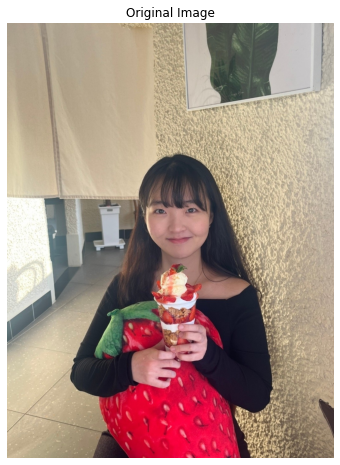

In [2]:
# Step 2: 이미지 불러오기
img_bgr = cv2.imread(my_image_path)  # 원본 이미지 (BGR 포맷)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # RGB 이미지로 변환

# 이미지 출력
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

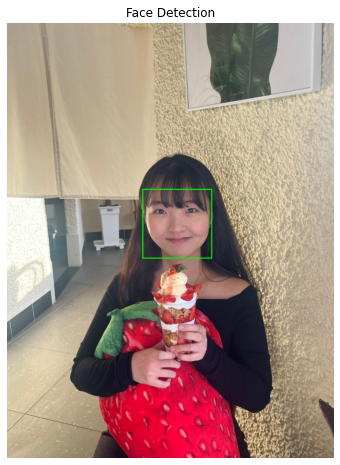

In [3]:
# Step 3: 얼굴 검출 - dlib의 HOG 기반 얼굴 검출기 사용
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)  # 이미지 피라미드 레벨 1로 설정

# 검출된 얼굴에 바운딩 박스 그리기
img_with_face = img_rgb.copy()
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_with_face, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

plt.figure(figsize=(8, 8))
plt.imshow(img_with_face)
plt.title('Face Detection')
plt.axis('off')
plt.show()

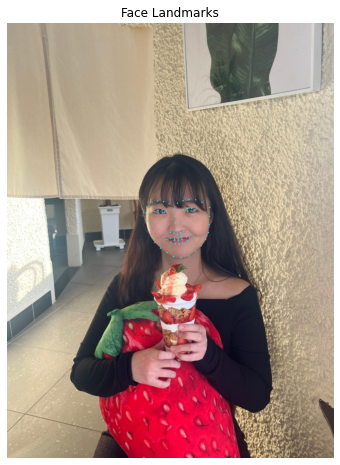

In [25]:
# Step 4: 얼굴 랜드마크 검출
# 랜드마크 예측기 모델 로드
model_path = 'aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 각 얼굴마다 랜드마크 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

    
# print(list_landmarks)
# 랜드마크 표시하기
img_with_landmarks = img_rgb.copy()
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_with_landmarks, point, 2, (0, 255, 255), -1)

plt.figure(figsize=(8, 8))
plt.imshow(img_with_landmarks)
plt.title('Face Landmarks')
plt.axis('off')
plt.show()

스티커 중심점: (550, 691)
스티커 크기: (224, 112)


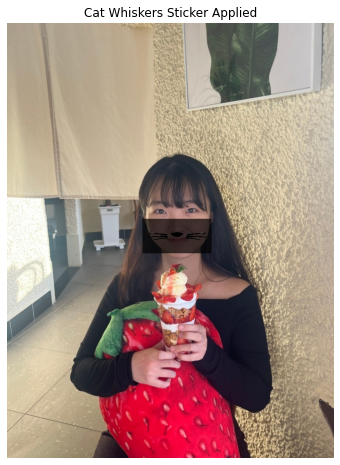

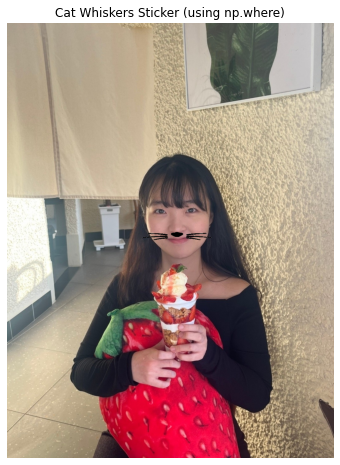

In [11]:
# Step 5: 스티커 적용 위치 계산
# 고양이 수염은 코와 입 사이에 위치하는 것이 자연스러움
# 코 끝(33)과 상단 입술의 중앙(51)의 중간점을 사용
def get_whiskers_position(landmarks):
    nose_tip = landmarks[33]  # 코 끝점
    upper_lip = landmarks[51]  # 윗 입술 중앙
    
    # 코와 입술 사이의 중간점 계산
    whiskers_x = nose_tip[0]
    whiskers_y = (nose_tip[1] + upper_lip[1]) // 2
    
    return whiskers_x, whiskers_y

# 스티커 적용 위치 계산 (첫 번째 얼굴에 대해)
if list_landmarks:
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        center_x, center_y = get_whiskers_position(landmark)
        
        # 얼굴 크기에 비례하여 스티커 크기 조정
        face_width = dlib_rect.width()
        sticker_width = face_width  # 얼굴 너비에 맞춤
        sticker_height = sticker_width // 2  # 너비:높이 = 2:1 비율로 조정
        
        print(f'스티커 중심점: ({center_x}, {center_y})')
        print(f'스티커 크기: ({sticker_width}, {sticker_height})')

        # 스티커 이미지 로드 및 크기 조정
        whiskers_img = cv2.imread(whiskers_path, cv2.IMREAD_UNCHANGED)
        if whiskers_img is None:
            print(f"경고: 스티커 이미지를 로드할 수 없습니다. 경로를 확인하세요: {whiskers_path}")
            whiskers_img = np.zeros((sticker_height, sticker_width, 4), dtype=np.uint8)
        else:
            whiskers_img = cv2.resize(whiskers_img, (sticker_width, sticker_height))
        
        # 스티커 알파 채널 확인 및 처리
        if whiskers_img.shape[2] == 4:  # 알파 채널이 있는 경우
            alpha_channel = whiskers_img[:, :, 3]
            rgb_channels = whiskers_img[:, :, :3]
            
            # BGR에서 RGB로 변환 (OpenCV는 BGR 포맷으로 이미지를 로드)
            rgb_channels = cv2.cvtColor(rgb_channels, cv2.COLOR_BGR2RGB)
            
            # 알파 채널을 마스크로 사용
            _, mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
        else:  # 알파 채널이 없는 경우
            # 이미지의 배경을 흰색으로 가정하고 마스크 생성
            gray = cv2.cvtColor(whiskers_img, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            mask_inv = cv2.bitwise_not(mask)
            rgb_channels = cv2.cvtColor(whiskers_img, cv2.COLOR_BGR2RGB)

        # Step 6: 스티커 적용하기
        # 스티커 위치 계산 (중심에서 왼쪽 상단으로 변환)
        x = center_x - sticker_width // 2
        y = center_y - sticker_height // 2
        
        # 이미지 경계 검사 및 보정
        if x < 0:
            mask = mask[:, -x:]
            mask_inv = mask_inv[:, -x:]
            rgb_channels = rgb_channels[:, -x:]
            sticker_width += x
            x = 0
        
        if y < 0:
            mask = mask[-y:, :]
            mask_inv = mask_inv[-y:, :]
            rgb_channels = rgb_channels[-y:, :]
            sticker_height += y
            y = 0
        
        # 이미지 오른쪽, 아래쪽 경계 검사
        if x + sticker_width > img_rgb.shape[1]:
            sticker_width = img_rgb.shape[1] - x
            mask = mask[:, :sticker_width]
            mask_inv = mask_inv[:, :sticker_width]
            rgb_channels = rgb_channels[:, :sticker_width]
        
        if y + sticker_height > img_rgb.shape[0]:
            sticker_height = img_rgb.shape[0] - y
            mask = mask[:sticker_height, :]
            mask_inv = mask_inv[:sticker_height, :]
            rgb_channels = rgb_channels[:sticker_height, :]
        
        # 마스크 적용 영역
        roi = img_rgb[y:y+sticker_height, x:x+sticker_width]
        
        # Step 7: 자연스러운 합성을 위한 가중치 적용
        # 원본 이미지와 스티커 사이의 가중치 합성 (알파 블렌딩)
        alpha = 0.7  # 스티커 투명도 (0.0 ~ 1.0)
        
        # 마스크를 이용해 원본 이미지 영역 추출
        roi_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        
        # 마스크를 이용해 스티커 이미지 영역 추출
        roi_fg = cv2.bitwise_and(rgb_channels[:sticker_height, :sticker_width], 
                               rgb_channels[:sticker_height, :sticker_width], 
                               mask=mask[:sticker_height, :sticker_width])
        
        # 가중치 합성
        dst = cv2.addWeighted(roi_bg, 1-alpha, roi_fg, alpha, 0)
        
        # 합성 결과를 원본 이미지에 적용
        img_result = img_rgb.copy()
        img_result[y:y+sticker_height, x:x+sticker_width] = dst

        # 결과 이미지 출력
        plt.figure(figsize=(8, 8))
        plt.imshow(img_result)
        plt.title('Cat Whiskers Sticker Applied')
        plt.axis('off')
        plt.show()
        
        # Step 8: 개선된 스티커 적용 (가중치 없이 np.where 사용)
        img_result2 = img_rgb.copy()
        # 스티커 영역 추출
        sticker_area = img_result2[y:y+sticker_height, x:x+sticker_width]
        
        # np.where를 사용하여 마스크 기반으로 합성
        # 마스크가 0인 부분(배경)은 원본 이미지, 그렇지 않은 부분은 스티커 이미지
        sticker_area = np.where(mask[:sticker_height, :sticker_width, np.newaxis] == 0, 
                              sticker_area, 
                              rgb_channels[:sticker_height, :sticker_width]).astype(np.uint8)
        
        img_result2[y:y+sticker_height, x:x+sticker_width] = sticker_area
        
        plt.figure(figsize=(8, 8))
        plt.imshow(img_result2)
        plt.title('Cat Whiskers Sticker (using np.where)')
        plt.axis('off')
        plt.show()

In [22]:
# Step 9: 다양한 각도에서의 테스트를 위한 함수 정의
def apply_sticker(image_path, sticker_path):
    """다양한 이미지에 스티커를 적용하는 함수"""
    # 이미지 로드
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 얼굴 검출
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    
    if len(faces) == 0:
        return img_rgb, "얼굴을 찾을 수 없습니다."
    
    # 랜드마크 검출
    predictor = dlib.shape_predictor(model_path)
    
    result_img = img_rgb.copy()
    messages = []
    
    for face in faces:
        landmarks = predictor(img_rgb, face)
        landmarks_points = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)]
        
        # 수염 위치 계산
        center_x, center_y = get_whiskers_position(landmarks_points)
        
        # 스티커 크기 계산
        face_width = face.width()
        sticker_width = face_width
        sticker_height = sticker_width // 2
        
        # 스티커 로드 및 크기 조정
        whiskers = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
        if whiskers is None:
            messages.append("스티커 이미지를 로드할 수 없습니다.")
            continue
            
        whiskers = cv2.resize(whiskers, (sticker_width, sticker_height))
        
        # 알파 채널 처리
        if whiskers.shape[2] == 4:
            alpha = whiskers[:, :, 3]
            whiskers_rgb = cv2.cvtColor(whiskers[:, :, 0:3], cv2.COLOR_BGR2RGB)
            _, mask = cv2.threshold(alpha, 1, 255, cv2.THRESH_BINARY)
        else:
            gray = cv2.cvtColor(whiskers, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            whiskers_rgb = cv2.cvtColor(whiskers, cv2.COLOR_BGR2RGB)
        
        mask_inv = cv2.bitwise_not(mask)
        
        # 스티커 위치 계산
        x = center_x - sticker_width // 2
        y = center_y - sticker_height // 2
        
        # 이미지 경계 검사
        if x < 0:
            whiskers_rgb = whiskers_rgb[:, -x:]
            mask = mask[:, -x:]
            mask_inv = mask_inv[:, -x:]
            sticker_width += x
            x = 0
        
        if y < 0:
            whiskers_rgb = whiskers_rgb[-y:, :]
            mask = mask[-y:, :]
            mask_inv = mask_inv[-y:, :]
            sticker_height += y
            y = 0
        
        if x + sticker_width > img_rgb.shape[1]:
            sticker_width = img_rgb.shape[1] - x
            whiskers_rgb = whiskers_rgb[:, :sticker_width]
            mask = mask[:, :sticker_width]
            mask_inv = mask_inv[:, :sticker_width]
        
        if y + sticker_height > img_rgb.shape[0]:
            sticker_height = img_rgb.shape[0] - y
            whiskers_rgb = whiskers_rgb[:sticker_height, :]
            mask = mask[:sticker_height, :]
            mask_inv = mask_inv[:sticker_height, :]
        
        # 스티커 적용 영역 (시각화하지 않음)
        roi = result_img[y:y+sticker_height, x:x+sticker_width]
        
        try:
            # 수염 부분만 그리기
            gray = cv2.cvtColor(whiskers_rgb, cv2.COLOR_RGB2GRAY)
            _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            
            # 수염만 검은색으로 그리기 (ROI 영역 표시 없이)
            for i in range(roi.shape[0]):
                for j in range(roi.shape[1]):
                    if thresh[i, j] > 0:  # 수염 부분이면
                        roi[i, j] = [0, 0, 0]  # 검은색으로
            
            # 결과 적용 (ROI 영역 표시 없이)
            result_img[y:y+sticker_height, x:x+sticker_width] = roi
            
        except Exception as e:
            messages.append(f"스티커 적용 중 오류 발생: {str(e)}")
    
    return result_img, "\n".join(messages) if messages else "성공적으로 스티커를 적용했습니다."
            



테스트 1: 성공적으로 스티커를 적용했습니다.


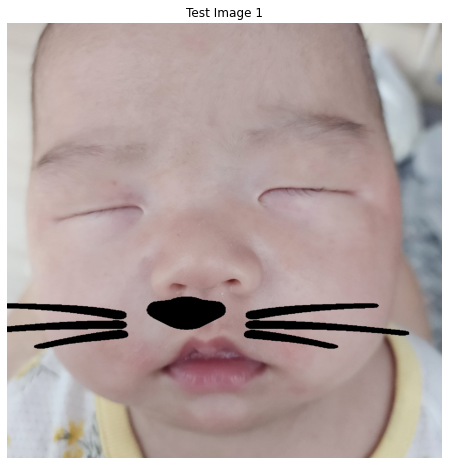

테스트 2: 얼굴을 찾을 수 없습니다.


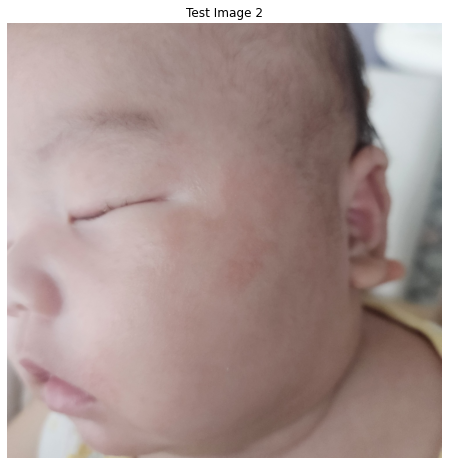

In [23]:
test_images = [
    'aiffel/camera_sticker/images/baby1.jpg',
    'aiffel/camera_sticker/images/baby2.jpg'
]

for i, img_path in enumerate(test_images):
    result, msg = apply_sticker(img_path, whiskers_path)
    print(f"테스트 {i+1}: {msg}")
    plt.figure(figsize=(8, 8))
    plt.imshow(result)
    plt.title(f'Test Image {i+1}')
    plt.axis('off')
    plt.show()